In [1]:
from FME.interpolators.finite_difference_interpolator import FiniteDifferenceInterpolator as FDI
from FME.supports.structured_grid import StructuredGrid
from FME.modelling.features.geological_feature import GeologicalFeatureInterpolator
# from FME.modelling.features.faulted_geological_feature import FaultedGeologicalFeature
from FME.visualisation.model_visualisation import LavaVuModelViewer
# from FME.modelling.structural_frame import StructuralFrameBuilder, StructuralFrame
# from FME.modelling.fault.fault_segment import FaultSegment
import numpy as np
import lavavu
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [5]:
dips = pd.read_csv('Dips.csv',delimiter=';')
points_file_names = ['APoints.csv','BPoints.csv','CPoints.csv','DPoints.csv']
section_file_names = ['ASection.csv','BSection.csv','CSection.csv','DSection.csv']

# import all of the csv into the same dataframe
dfs = []
for f in points_file_names:
    dfs.append(pd.read_csv(f,delimiter=';'))
points = pd.concat(dfs,axis=0,ignore_index=True)
# sections
dfs = []
for f in section_file_names:
    dfs.append(pd.read_csv(f,delimiter=';'))
sections = pd.concat(dfs,axis=0,ignore_index=True)
# apoints = pd.read_csv('APoints.csv',delimiter=';')
# asection = pd.read_csv('ASection.csv',delimiter=';')



In [6]:
origin = (548800, 7816600, -11010,)
nsteps = np.array((38,55,30))
# nsteps = np.array((19,28,15))

step_vector = (100,100,90)
grid = StructuredGrid(origin=origin, nsteps=nsteps,step_vector=step_vector)



In [7]:
print(origin[1]+step_vector[1]*nsteps[1])
print(origin[0]+step_vector[0]*nsteps[0])
print(origin[2]+step_vector[2]*nsteps[2])

7822100
552600
-8310


In [8]:
interpolator = FDI(grid)
stratigraphy_builder = GeologicalFeatureInterpolator(
    interpolator=interpolator,
    name='stratigraphy')
solver = 'lu'
for i, r in points.iterrows():
    stratigraphy_builder.add_point([r['X'],r['Y'],r['Z']],r['Strati'])#xy[0][0],xy[1][0],z],r['value'],itype=r['itype'])
for i, r in sections.iterrows():
    stratigraphy_builder.add_point([r['X'],r['Y'],r['Z']],r['Strati'])#xy[0][0],xy[1][0],z],r['value'],itype=r['itype'])
for i, r in dips.iterrows():
    stratigraphy_builder.add_planar_constraint([r['X'],r['Y'],r['Z']],[r['OrientX'],r['OrientY'],r['OrientZ']])
# stratigraphy_builder.add_point([6.1,0.1,1.1],0.)
# stratigraphy_builder.add_point([6.1,0.1,2.1],1.)
# stratigraphy_builder.add_strike_and_dip([1,1,1],90.,0.)
unique = np.unique(stratigraphy_builder.interpolator.get_control_points()[:,3])

In [10]:
stratigraphy = stratigraphy_builder.build(    
    solver='cg',
    dxy=.1,
    dyz=.1,
    dxz= .1,
    dxx= .2,
    dyy= .2,
    dzz= .2,
)


341642 (341642, 62700)
Conjugate gradient converged


683284 (683284, 62700)
Conjugate gradient converged
Creating isosurface for 0.000000
Creating isosurface for 60.000000
Creating isosurface for 250.000000
Creating isosurface for 330.000000
1024926 (1024926, 62700)
Conjugate gradient converged
Creating isosurface for 30.000000
Creating isosurface for 125.000000
Creating isosurface for 300.000000
[100 100  90]



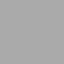

In [11]:
viewer = LavaVuModelViewer(background="white")
viewer.plot_isosurface(stratigraphy, slices=unique, colour='blue')
viewer.plot_isosurface(stratigraphy, slices=[30,125,300], colour='red')

viewer.plot_value_data(stratigraphy.support.interpolator.get_control_points()[:,:3],
                       stratigraphy.support.interpolator.get_control_points()[:,3],
                       'val')
viewer.plot_vector_data(
    stratigraphy.support.interpolator.get_gradient_control()[:,:3],
    stratigraphy.support.interpolator.get_gradient_control()[:,3:],
    'grad')
print(grid.step_vector)
viewer.interactive()

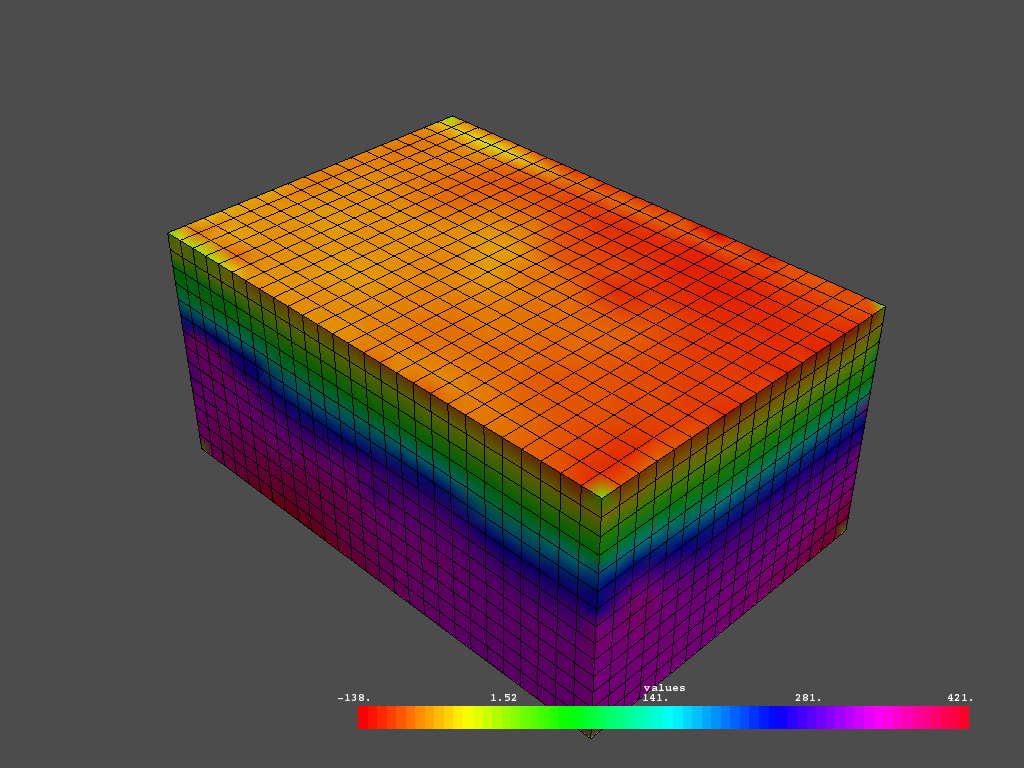

In [8]:
import pyvista
vgrid = pyvista.UniformGrid()
vgrid.dimensions = grid.nsteps
vgrid.origin=grid.origin
vgrid.spacing = grid.step_vector

vgrid.point_arrays['values'] = stratigraphy.support.get_node_values().reshape(grid.nsteps).flatten(order='C')
vgrid.plot(show_edges=True,cmap=plt.get_cmap('hsv'))


In [10]:
from skimage.measure import marching_cubes_lewiner

In [14]:
verts, faces, normals, values = marching_cubes_lewiner(
            grid.properties['stratigraphy'].reshape(grid.nsteps,order='C'),
            0,
            spacing=grid.step_vector)

In [15]:
print(verts, faces)

[[0.00000000e+00 0.00000000e+00 1.18889460e-16]
 [0.00000000e+00 1.23934465e-16 0.00000000e+00]
 [1.17527259e-16 0.00000000e+00 0.00000000e+00]
 ...
 [3.24746628e+03 3.60000000e+03 3.60000000e+02]
 [3.24005241e+03 3.80000000e+03 1.08000000e+03]
 [3.20587463e+03 4.00000000e+03 1.80000000e+03]] [[  2   1   0]
 [  5   4   3]
 [  4   6   3]
 ...
 [566 699 564]
 [699 574 563]
 [574 699 566]]


In [16]:
verts+grid.origin[None,:]

array([[ 548800.        , 7816600.        ,  -11010.        ],
       [ 548800.        , 7816600.        ,  -11010.        ],
       [ 548800.        , 7816600.        ,  -11010.        ],
       ...,
       [ 552047.46627808, 7820200.        ,  -10650.        ],
       [ 552040.05241394, 7820400.        ,   -9930.        ],
       [ 552005.87463379, 7820600.        ,   -9210.        ]])